In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:2')
else:
    device = torch.device('cpu')
    
print(device)
# device = torch.device('cpu')

cuda:2


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out

In [4]:
data_df = pd.read_csv("all_data_lake_modeling_in_time.csv")
data_df = data_df.drop(columns=['time'])
data_df

,depth,AirTemp_degC,Longwave_Wm-2,Latent_Wm-2,Sensible_Wm-2,Shortwave_Wm-2,lightExtinct_m-1,ShearVelocity_mS-1,ShearStress_Nm-2,Area_m2,...,buoyancy,diffusivity,temp_heat00,temp_diff01,day_of_year,time_of_day,temp_mix02,temp_conv03,obs_temp,input_obs
0,1,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000000,0.000037,11.467275,11.467275,155,1,11.545011,11.570472,16.409,16.350
1,2,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000000,0.000037,11.650008,11.627332,155,1,11.545011,11.570472,16.480,16.426
2,3,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000271,0.000021,11.650008,11.631393,155,1,11.631393,11.575860,16.130,16.088
3,4,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000278,0.000021,11.394500,11.393058,155,1,11.393058,11.393058,15.827,15.789
4,5,10.715021,678.292163,-152.775961,-4.194743,0.0,0.255324,1.085796,0.002290,36000000.0,...,0.000185,0.000024,11.123803,11.130929,155,1,11.130929,11.130929,16.270,16.240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35370,21,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000282,0.000020,6.772435,6.773650,213,23,6.773650,6.773650,12.204,12.204
35371,22,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000191,0.000024,5.995879,5.996763,213,23,5.996763,5.996763,12.204,12.204
35372,23,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000102,0.000032,5.229508,5.230045,213,23,5.230045,5.230045,12.204,12.204
35373,24,13.595026,718.547070,-230.901096,-40.903561,0.0,2.069661,2.343012,0.007849,36000000.0,...,0.000013,0.000037,4.467800,4.468109,213,23,4.468109,4.468109,12.204,12.204


In [5]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 1415
Number of training points: 21225


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

# #performing normalization on all the columns
# scaler = StandardScaler()
# scaler.fit(train_data)
# train_data = scaler.transform(train_data)
# test_data = scaler.transform(test_data)

# Training Heat Diffusion Model

In [7]:
## Sorry did not have the latest data....

# input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
#                 'lightExtinct_m-1','Area_m2', 
#                  'day_of_year', 'time_of_day', 'temp_initial00']
# output_columns = ['temp_heat01']

input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'input_temp'] # REMOVED AREA AS A FEATURE
output_columns = ['temp_heat00']

input_column_ix = [data_df.columns.get_loc(column) for column in input_columns]
output_column_ix = [data_df.columns.get_loc(column) for column in output_columns]

X_train, X_test = train_data[:,input_column_ix], test_data[:,input_column_ix]
y_train, y_test = train_data[:,output_column_ix], test_data[:,output_column_ix]

In [8]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (21225, 13), X_test: (14150, 13)
y_train: (21225, 1), y_test: (14150, 1)


## Missing Data Mask

In [9]:
############################################################################
# Includes masking
############################################################################

class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X, Y, mask=None):
        self.X = X
        self.Y = Y
        if mask is None:
            self.mask = np.ones_like(self.Y)
        else:
            self.mask = mask
        
    def __getitem__(self, index):
        return self.X[index], self.Y[index], self.mask[index]
    
    def __len__(self):
        return len(self.X)
    
############################################################################

In [10]:
# create a mask which is the shape of Y_train.. The mask should have 1's if you have the labels otherwise it should be 0.
# for this case we have labels for every data point, hence the Y_mask = 1
y_train_mask = np.ones_like(y_train)
y_test_mask = np.ones_like(y_test)

# #artifically dropping out some labels
# y_train_mask = np.random.binomial(1, 0.8, size=y_train.shape)

In [11]:
#keeping track of the mean and standard deviations
input_mean, input_std = np.mean(X_train, axis=0), np.std(X_train, axis=0)


### Output mean cannot be computed this way now.. since there are missing values
# output_mean, output_std = train_mean[output_column_ix], train_std[output_column_ix]

## New-way of computing the output means and standard devs.
y_train[y_train_mask==0] = np.nan #making the values that are missing as nan
output_mean, output_std = np.nanmean(y_train, axis=0), np.nanstd(y_train, axis=0)

#normalizing inputs
X_train = (X_train - input_mean)/input_std
X_test = (X_test - input_mean)/input_std

#normalizing outputs
y_train = (y_train - output_mean)/output_std
y_test = (y_test - output_mean)/output_std

# making the y_maskvalye = 0 (for easy loss computation)
y_train[y_train_mask==0] = 0
y_test[y_test_mask==0] = 0

In [12]:
# Create data set
batch_size = 1024
train_dataset = DataGenerator(X_train, y_train, y_train_mask)
test_dataset = DataGenerator(X_test, y_test, y_test_mask)

# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [13]:
layers = [X_train.shape[-1], 32, 32, y_train.shape[-1]]

model = MLP(layers, activation="gelu").to(device)

Initializing Network with Xavier Initialization..


In [14]:
lr = 1e-3
decay_rate = 0.1
decay_steps = 500
    
optimizer = torch.optim.Adam(model.parameters(), lr=lr, 
                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

In [15]:
print(model)

MLP(
  (activation): GELU()
  (layers): Sequential(
    (layer_0): Linear(in_features=13, out_features=32, bias=True)
    (activation_0): GELU()
    (layer_1): Linear(in_features=32, out_features=32, bias=True)
    (activation_1): GELU()
    (layer_2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [16]:
n_epochs = 1000

train_loss = []
test_loss = []
for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    model.train()
    for x, y, mask in iter(train_loader):
        x, y, mask = x.to(device).float(), y.to(device).float(), mask.to(device).float()
        optimizer.zero_grad()
        pred = model(x)
#         loss = criterion(pred, y)
        loss = (((pred - y)*mask)**2).sum()/mask.sum() #normalized masked-MSE loss
        loss.backward()
        optimizer.step()
        loss_epoch += loss.detach().item()
    lr_scheduler.step()
    
    if it % 50 == 0:
        train_loss.append(loss_epoch/len(train_loader))
        model.eval()
        test_loss_epoch = 0
        for x, y, mask in iter(test_loader):
            x, y, mask = x.to(device).float(), y.to(device).float(), mask.to(device).float()
            pred = model(x)
            loss = (((pred - y)*mask)**2).sum()/mask.sum()
            test_loss_epoch += loss.detach().item()
        test_loss.append(test_loss_epoch/len(test_loader))
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Test_loss: {test_loss[-1]}")
    

  0%|          | 1/1000 [00:00<05:42,  2.91it/s]

Epoch : 0, Train_loss: 0.6345908656006768, Test_loss: 0.6769847167389733


  5%|▌         | 51/1000 [00:13<04:59,  3.17it/s]

Epoch : 50, Train_loss: 0.0005975984801937427, Test_loss: 0.05138980730303696


 10%|█         | 101/1000 [00:26<04:27,  3.36it/s]

Epoch : 100, Train_loss: 0.00018087563581676002, Test_loss: 0.06625578006995576


 15%|█▌        | 151/1000 [00:40<04:14,  3.33it/s]

Epoch : 150, Train_loss: 0.00010490366618060285, Test_loss: 0.08743171141083751


 20%|██        | 201/1000 [00:53<03:54,  3.40it/s]

Epoch : 200, Train_loss: 7.25954676107947e-05, Test_loss: 0.07060473601865981


 25%|██▌       | 251/1000 [01:06<03:41,  3.38it/s]

Epoch : 250, Train_loss: 5.3227885516770625e-05, Test_loss: 0.040005839130442054


 30%|███       | 301/1000 [01:19<03:21,  3.47it/s]

Epoch : 300, Train_loss: 4.595825763923737e-05, Test_loss: 0.01592769201046654


 35%|███▌      | 351/1000 [01:32<03:21,  3.23it/s]

Epoch : 350, Train_loss: 3.8428394050459335e-05, Test_loss: 0.005474949908343011


 40%|████      | 401/1000 [01:45<02:53,  3.45it/s]

Epoch : 400, Train_loss: 3.2135866301056616e-05, Test_loss: 0.0032936814823187888


 45%|████▌     | 451/1000 [01:58<02:46,  3.29it/s]

Epoch : 450, Train_loss: 3.5182219237737756e-05, Test_loss: 0.002941264014225453


 50%|█████     | 501/1000 [02:11<02:27,  3.39it/s]

Epoch : 500, Train_loss: 2.527545499712384e-05, Test_loss: 0.0031305895827244967


 55%|█████▌    | 551/1000 [02:24<02:13,  3.35it/s]

Epoch : 550, Train_loss: 2.4110660455161926e-05, Test_loss: 0.003168433900490137


 60%|██████    | 601/1000 [02:37<01:57,  3.40it/s]

Epoch : 600, Train_loss: 2.4134515461766915e-05, Test_loss: 0.0034300919443402173


 65%|██████▌   | 651/1000 [02:50<01:42,  3.39it/s]

Epoch : 650, Train_loss: 2.3925691667023957e-05, Test_loss: 0.003430935071914324


 70%|███████   | 701/1000 [03:03<01:26,  3.45it/s]

Epoch : 700, Train_loss: 2.3781978857836554e-05, Test_loss: 0.0033458049666868256


 75%|███████▌  | 751/1000 [03:16<01:17,  3.22it/s]

Epoch : 750, Train_loss: 2.32439489904902e-05, Test_loss: 0.0034913769590535332


 80%|████████  | 801/1000 [03:29<00:57,  3.46it/s]

Epoch : 800, Train_loss: 2.3107234353249494e-05, Test_loss: 0.0035852872803973567


 85%|████████▌ | 851/1000 [03:42<00:45,  3.28it/s]

Epoch : 850, Train_loss: 2.247589899135554e-05, Test_loss: 0.003516605061512174


 90%|█████████ | 901/1000 [03:55<00:29,  3.39it/s]

Epoch : 900, Train_loss: 2.1953139540051953e-05, Test_loss: 0.0036872719917612684


 95%|█████████▌| 951/1000 [04:08<00:14,  3.35it/s]

Epoch : 950, Train_loss: 2.1922283416469802e-05, Test_loss: 0.003755720012122765


100%|██████████| 1000/1000 [04:20<00:00,  3.84it/s]


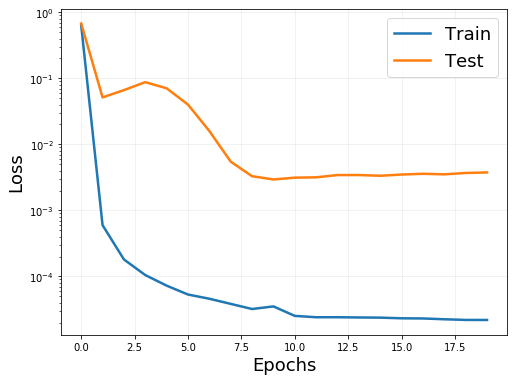

In [17]:
plt.figure(figsize=(8,6))
plt.plot(train_loss, label="Train", linewidth=2.5)
plt.plot(test_loss, label="Test", linewidth=2.5)
plt.grid("on", alpha=0.2)
plt.legend(fontsize=18)
plt.yscale("log")
plt.xlabel("Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.show()

# Evaluating Results

In [18]:
def rmse(true, pred, mask):
    mean_squared_error = (((true-pred)*mask)**2).sum()/mask.sum()
    return (mean_squared_error**0.5).detach().cpu().numpy()

def compute_metrics(model, loader, mean=0.0, std=1.0):
    model.eval()
    y_ = []
    pred_ = []
    mask_ = []
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    for x, y, mask in iter(loader):
        x, y, mask = x.to(device).float(), y.to(device).float(), mask.to(device).float()
        pred = model(x)
        y = y * std + mean
        pred = pred * std + mean
        y_.append(y)
        pred_.append(pred)
        mask_.append(mask)
        
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    mask_ = torch.cat(mask_, dim=0)
    
    rmse_temp = rmse(y_[:,0], pred_[:,0], mask_[:,0])
    return rmse_temp

In [19]:
rmse_temp = compute_metrics(model, test_loader,  mean = output_mean, std = output_std)
print(f"Test Rmse of Temp: {rmse_temp}")

Test Rmse of Temp: 0.3611942166487372


In [20]:
rmse_temp = compute_metrics(model, train_loader,  mean = output_mean, std = output_std)
print(f"Train Rmse of Temp: {rmse_temp}")

Train Rmse of Temp: 0.027500638432425253


# Saving Model

In [21]:
PATH = f"./saved_models/heating_model_time.pth"
torch.save(model.state_dict(), PATH)

In [22]:
output_mean

array([11.34450246])